## MWE (Understanding the Ensemble Tools)

Goal of this section is to adapt a vanilla example from the tutorial with our reduced framework (i.e., only store moment information.)

In [1]:
using DifferentialEquations

In [2]:
using Plots, Statistics, StatsBase

### Baseline

We'll use a simple 2 $\times$ 2 ODE with the initial condition varying between ensemble members

In [3]:
prob = ODEProblem((u,p,t)->1.01u, [0.5 0.5; 0.25 0.25], (0.0, 10.0))

ODEProblem with uType Array{Float64,2} and tType Float64. In-place: false
timespan: (0.0, 10.0)
u0: [0.5 0.5; 0.25 0.25]

In [4]:
# from tutorial (varies initial conditions across ensembles)
function prob_func(prob,i,repeat)
  ODEProblem(prob.f, rand()*prob.u0,prob.tspan)
end

prob_func (generic function with 1 method)

In [5]:
ensemble_prob = EnsembleProblem(prob,prob_func=prob_func)
sim = solve(ensemble_prob,Tsit5(),EnsembleThreads(),trajectories=5)

EnsembleSolution Solution of length 5 with uType:
ODESolution{Float64,3,Array{Array{Float64,2},1},Nothing,Nothing,Array{Float64,1},Array{Array{Array{Float64,2},1},1},ODEProblem{Array{Float64,2},Tuple{Float64,Float64},false,Nothing,ODEFunction{false,getfield(Main, Symbol("##3#4")),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Nothing,DiffEqBase.StandardODEProblem},Tsit5,OrdinaryDiffEq.InterpolationData{ODEFunction{false,getfield(Main, Symbol("##3#4")),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Array{Array{Float64,2},1},Array{Float64,1},Array{Array{Array{Float64,2},1},1},OrdinaryDiffEq.Tsit5ConstantCache{Float64,Float64}},DiffEqBase.DEStats}

And we can plot:

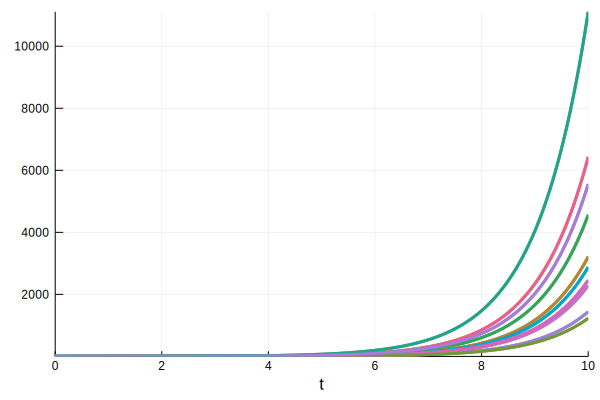

In [6]:
plot(sim)

In [7]:
summ = EnsembleSummary(sim);

In [8]:
using Plots
plotly() # per tutorial

Plots.PlotlyBackend()

In [9]:
plot(summ, idxs = [1, 2], error_style = :bars, title = "First and Second Indices, Mean and Variance")

<!DOCTYPE html>
 
 
 Plots.jl

### With rand(2) parameter (problem-specific random shock)

In [10]:
# stores random value in p
function prob_func(prob,i,repeat)
  rand_vec = rand(2);
  p = (rand_vec = rand_vec,)
  ODEProblem(prob.f, rand()*prob.u0, prob.tspan, p)
end

prob_func (generic function with 1 method)

In [11]:
# accesses from sol.prob.p
function output_func(sol, i)
    display(sol.prob.p.rand_vec[2]) # should be different per run
    return sol, false 
end

output_func (generic function with 1 method)

In [12]:
ensemble_prob = EnsembleProblem(prob,prob_func=prob_func,output_func=output_func);
sim = solve(ensemble_prob,Tsit5(),trajectories=5);

0.9282126613900086

0.6109869365584315

0.749992259454753

0.05066694129879945

0.5362039239036995

In [13]:
plot(sim)

<!DOCTYPE html>
 
 
 Plots.jl

### Full Setup with Callback and Moments

In [14]:
solution_summary(u, t, integrator) = [minimum(u[1:end]), mean(u[1:end]), maximum(u[1:end])] # take summary stats on the solution at each time point
saved_values = SavedValues(Float64, Array{Float64,1}) 
p = (saved_values = saved_values,);

In [15]:
prob = ODEProblem((u,p,t)->1.01u, [0.5 0.5; 0.2 0.25], (0.0, 10.0), p);

In [16]:
cb = SavingCallback(solution_summary, saved_values);

In [17]:
# solve once, as a sanity check
sol = solve(prob, callback = cb, save_everystep = false);
sol.retcode

:Success

In [18]:
sol.u # should be very small

2-element Array{Array{Float64,2},1}:
 [0.5 0.5; 0.2 0.25]               
 [12168.5 12168.5; 4867.39 6084.24]

In [19]:
@show length(saved_values.t)
saved_values.saveval # should give us one set for each time point

length(saved_values.t) = 17


17-element Array{Array{Float64,1},1}:
 [0.2, 0.3625, 0.5]            
 [0.221181, 0.400891, 0.552953]
 [0.283599, 0.514023, 0.708998]
 [0.396604, 0.718846, 0.991511]
 [0.595177, 1.07876, 1.48794]  
 [0.968125, 1.75473, 2.42031]  
 [1.69274, 3.0681, 4.23186]    
 [3.17633, 5.75709, 7.94081]   
 [6.35376, 11.5162, 15.8844]   
 [13.4775, 24.428, 33.6938]    
 [30.1262, 54.6038, 75.3156]   
 [70.5552, 127.881, 176.388]   
 [172.159, 312.038, 430.397]   
 [435.43, 789.216, 1088.57]    
 [1136.21, 2059.39, 2840.54]   
 [3046.04, 5520.94, 7615.09]   
 [4867.39, 8822.15, 12168.5]   

Now we do the ensemble stuff.

In [20]:
# problem_alteration function
function prob_func(prob,i,repeat)
  ODEProblem(prob.f, rand()*prob.u0, prob.tspan, p) 
end

prob_func (generic function with 1 method)

In [21]:
function output_func(sol, i)
    @show length(sol.t)
    @show length(sol.prob.p.saved_values.t)
    @show sol.prob.p.saved_values.saveval[3][1] # for uniqueness
    stats = hcat(sol.prob.p.saved_values.saveval...)
    return (u = stats,), false # return the statistics from each run
end 

output_func (generic function with 1 method)

In [22]:
ensemble_prob = EnsembleProblem(prob,prob_func=prob_func,output_func=output_func);

In [23]:
sim = solve(ensemble_prob, output_func = output_func, prob_func = prob_func, trajectories = 10, save_everystep = false, callback = cb);

length(sol.t) = 2
length((((sol.prob).p).saved_values).t) = 17
((((sol.prob).p).saved_values).saveval[3])[1] = 0.12417853099500296
length(sol.t) = 2
length((((sol.prob).p).saved_values).t) = 17
((((sol.prob).p).saved_values).saveval[3])[1] = 0.027022637264664574
length(sol.t) = 2
length((((sol.prob).p).saved_values).t) = 17
((((sol.prob).p).saved_values).saveval[3])[1] = 0.11475958695328392
length(sol.t) = 2
length((((sol.prob).p).saved_values).t) = 17
((((sol.prob).p).saved_values).saveval[3])[1] = 0.04747172118388017
length(sol.t) = 2
length((((sol.prob).p).saved_values).t) = 17
((((sol.prob).p).saved_values).saveval[3])[1] = 0.19698469816348455
length(sol.t) = 2
length((((sol.prob).p).saved_values).t) = 17
((((sol.prob).p).saved_values).saveval[3])[1] = 0.2015039552775353
length(sol.t) = 2
length((((sol.prob).p).saved_values).t) = 17
((((sol.prob).p).saved_values).saveval[3])[1] = 0.2789026332498972
length(sol.t) = 2
length((((sol.prob).p).saved_values).t) = 17
((((sol.prob).p).save